In [3]:
%load_ext jupyter_black
import numpy as np
import pandas as pd
import csv
import os
import re
import json
import geemap
import requests
import io
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [4]:
from google.auth import compute_engine
import ee

credentials = compute_engine.Credentials(
    scopes=["https://www.googleapis.com/auth/earthengine"]
)
ee.Initialize(credentials)

## Get the info from the database

In [10]:
df = pd.read_csv(
    os.path.realpath(
        os.path.join(
            os.path.curdir,
            "..",
            "..",
            "data",
            "processed",
            "Wind_farm_lon_lat_geometry.csv",
        )
    ),
    header=None,
)

In [11]:
def get_csv_data(bucket_name, path, filename):
    from google.cloud import storage
    import pandas as pd

    # bucket_name = "wind-turbine-project-thibaud"

    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    # When you have your files in a subfolder of the bucket.
    my_prefix = path  # the name of the subfolder
    blobs = bucket.list_blobs(prefix=my_prefix, delimiter="/")
    for blob in blobs:
        if (
            blob.name != my_prefix
        ) and blob.name == path + filename:  # ignoring the subfolder itself
            file_name = blob.name.replace(my_prefix, "")
            blob.download_to_filename(file_name)  # download the file to the machine
            dff = pd.read_csv(file_name, header=None)  # load the data
    return dff

In [12]:
df = get_csv_data(
    "wind-turbine-project-thibaud",
    "image & ground truth/",
    "Wind_farm_lon_lat_geometry_batch1.csv",
)
df

,0,1,2,3,4,5,6,7
0,38,121.1333,33.3083,0.100,01/01/2022,31/03/2022,"{""type"": ""Polygon"", ""coordinates"": [[[121.0333...","[{'type': 'Polygon', 'coordinates': [[[121.233..."
1,38,121.1333,33.3083,0.100,01/03/2022,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.0333...","[{'type': 'Polygon', 'coordinates': [[[121.181..."
2,40,121.3750,33.4600,0.075,01/03/2022,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.3, 3...","[{'type': 'Polygon', 'coordinates': [[[121.435..."
3,40,121.3750,33.4600,0.075,01/10/2022,30/01/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.3, 3...","[{'type': 'Polygon', 'coordinates': [[[121.435..."
4,42,121.5927,33.3225,0.080,01/10/2022,30/01/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.5127...","[{'type': 'Polygon', 'coordinates': [[[121.669..."
...,...,...,...,...,...,...,...,...
298,34,113.7300,22.1200,0.050,01/03/2023,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[113.68, ...","[{'type': 'Polygon', 'coordinates': [[[113.716..."
299,35,113.4370,21.9075,0.070,01/03/2023,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[113.367,...","[{'type': 'Polygon', 'coordinates': [[[113.384..."
300,35,113.4370,21.9075,0.070,01/10/2022,30/01/2023,"{""type"": ""Polygon"", ""coordinates"": [[[113.367,...","[{'type': 'Polygon', 'coordinates': [[[113.383..."
301,37,121.4700,33.1600,0.100,01/03/2023,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.37, ...","[{'type': 'Polygon', 'coordinates': [[[121.397..."


In [13]:
def maskS2clouds(image):
    qa = image.select("QA60")

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [14]:
sentinel2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
    .map(maskS2clouds)
)

# Get the bands of the zone

In [15]:
def image_aglomeration(bands, roi_string):
    square = ee.Geometry(json.loads(roi_string))
    # square = GeoJson_string
    # find a suitable size of square in order to call the url
    oversize = True
    new_square = square
    subdivision = 1
    while oversize == True:
        try:
            url = sentinel2.median().getDownloadUrl(
                {"region": new_square, "scale": 10, "format": "NPY"}
            )
            lon, lat = new_square.centroid().getInfo()["coordinates"]
            corners = new_square.coordinates().getInfo()
            corner = corners[0][3]
            e = abs(corners[0][1][0] - corner[0])
            break
            # response = requests.get(url)
            # data = np.load(io.BytesIO(response.content))
            # return data
            # oversize = False
        except:
            corners = new_square.coordinates().getInfo()
            corner = corners[0][3]
            e = abs(corners[0][1][0] - corner[0]) / 2
            lon, lat = new_square.centroid().getInfo()["coordinates"]
            lon, lat = lon - e / 2, lat + e / 2
            new_square = ee.Geometry.Rectangle(
                [lon - e / 2, lat - e / 2, lon + e / 2, lat + e / 2]
            )
            subdivision = 4 * subdivision
    # recreate the array
    small_images = {}
    for i in range(int(subdivision**0.5)):
        for j in range(int(subdivision**0.5)):
            sq = ee.Geometry.Rectangle(
                [
                    (lon + j * 2 * e / 2) - e / 2,
                    (lat - i * 2 * e / 2) - e / 2,
                    (lon + j * 2 * e / 2) + e / 2,
                    (lat - i * 2 * e / 2) + e / 2,
                ]
            )
            url = sentinel2.median().getDownloadUrl(
                {"region": sq, "scale": 10, "format": "NPY"}
            )
            response = requests.get(url)
            data = np.load(io.BytesIO(response.content))
            small_images[str(i) + str(j)] = data
    side = int(np.sqrt(len(small_images.keys())))
    x_pix, y_pix = 0, 0
    for i in range(side):
        x_pix += small_images["0" + str(i)].shape[1]
        y_pix += small_images[str(i) + "0"].shape[0]
    x_pix, y_pix = x_pix - side + 1, y_pix - side + 1
    big_image = np.zeros((y_pix, x_pix), dtype=small_images["00"].dtype)
    # print(big_image)
    y_progress = 0
    for j in range(side):
        x_progress = 0
        for i in range(side):
            if j > 0:
                s_img = small_images[str(j) + str(i)][1:]
            else:
                s_img = small_images[str(j) + str(i)]
            if i > 0:
                s_img = s_img[:, 1:]
            big_image[
                y_progress : y_progress + s_img.shape[0],
                x_progress : x_progress + s_img.shape[1],
            ] = s_img
            x_progress += s_img.shape[1]
        y_progress += s_img.shape[0]
    return big_image

In [16]:
def groud_truth(matrix_size, roi, polygon_geom):
    y_pix, x_pix = matrix_size
    square = ee.Geometry(json.loads(roi))
    polys = eval(polygon_geom)
    polys_coordinates = [np.squeeze(poly["coordinates"]) for poly in polys]
    polygons = [Polygon(coords) for coords in polys_coordinates]
    square_coords = np.squeeze(square["coordinates"])
    x_min, x_max, y_min, y_max = (
        square_coords[:, 0].min(),
        square_coords[:, 0].max(),
        square_coords[:, 1].min(),
        square_coords[:, 1].max(),
    )
    x = np.linspace(
        x_min, x_max, x_pix
    )  # 500 is the number of points, adjust as needed
    y = np.linspace(y_max, y_min, y_pix)
    xv, yv = np.meshgrid(x, y)
    points = np.column_stack((xv.flatten(), yv.flatten()))
    mask = np.array(
        [any(polygon.contains(Point(p)) for polygon in polygons) for p in points]
    )
    mask = mask.reshape(xv.shape)
    return mask

# To be run once all the polygons have bee created

In [16]:
%%time
# for i in range(len(df)):
for i in [244]:
    band = image_aglomeration(sentinel2, df.iloc[i][6])
    mask = groud_truth(band.shape, df.iloc[i][6], df.iloc[i][7])
    np.save(
        os.path.realpath(
            os.path.join(
                os.path.curdir,
                "..",
                "..",
                "data",
                "processed",
                "masks",
                "masks_"
                + str(i)
                + "_field_"
                + str(df[0].iloc[i])
                + "_period_"
                + df[4].iloc[i].replace("/", "-")
                + "_to_"
                + df[5].iloc[i].replace("/", "-"),
            )
        ),
        mask,
    )
    np.save(
        os.path.realpath(
            os.path.join(
                os.path.curdir,
                "..",
                "..",
                "data",
                "processed",
                "bands",
                "bands_"
                + str(i)
                + "_field_"
                + str(df[0].iloc[i])
                + "_period_"
                + df[4].iloc[i].replace("/", "-")
                + "_to_"
                + df[5].iloc[i].replace("/", "-"),
            )
        ),
        band,
    )

CPU times: user 3min 41s, sys: 5.1 s, total: 3min 46s
Wall time: 1h 23min 13s


problem with importing:
49, 50 95, 96,209,210, 225

Look at field 154

## Create the mask of which have not been created

#### Inspect a folder in mask and band a display the diff 

In [122]:
bands_list.pop(bands_list.index(".ipynb_checkpoints"))

['bands_99_field_95_period_01-10-2022_to_30-01-2023.npy',
 'bands_123_field_108_period_01-03-2022_to_30-06-2023.npy',
 'bands_102_field_96_period_01-10-2022_to_30-01-2023.npy',
 'bands_45_field_66_period_01-03-2023_to_30-06-2023.npy',
 'bands_275_field_15_period_01-03-2023_to_30-06-2023.npy',
 'bands_13_field_47_period_01-03-2023_to_30-06-2023.npy',
 'bands_44_field_65_period_01-03-2023_to_30-06-2023.npy',
 'bands_78_field_84_period_01-03-2023_to_30-06-2023.npy',
 'bands_4_field_42_period_01-10-2022_to_30-01-2023.npy',
 'bands_242_field_179_period_01-10-2022_to_30-01-2023.npy',
 'bands_170_field_133_period_01-10-2022_to_30-01-2023.npy',
 'bands_228_field_170_period_01-03-2023_to_30-06-2023.npy',
 'bands_33_field_60_period_01-10-2022_to_30-01-2023.npy',
 'bands_34_field_60_period_01-03-2023_to_30-06-2023.npy',
 'bands_32_field_59_period_01-03-2023_to_30-06-2023.npy',
 'bands_200_field_150_period_01-03-2023_to_30-06-2023.npy',
 'bands_110_field_100_period_01-03-2023_to_30-06-2023.npy',
 

In [156]:
folder = "train"
bands_directory = os.path.realpath(
    os.path.join(os.path.curdir, "..", "..", "data", "processed", "bands", folder)
)
bands_list = os.listdir(bands_directory)
try:
    bands_list.pop(bands_list.index(".ipynb_checkpoints"))
except:
    a = 1

masks_directory = os.path.realpath(
    os.path.join(os.path.curdir, "..", "..", "data", "processed", "masks", folder)
)
masks_l = os.listdir(masks_directory)
try:
    masks_l.pop(masks_l.index(".ipynb_checkpoints"))
except:
    a = 1
pattern = "\w+_(\d+)_field_\d+"
masks_list = list()
size = list()
for band in bands_list:
    band_id = re.findall(pattern, band)
    present = False
    for mask in masks_l:
        mask_id = re.findall(pattern, mask)
        if band_id == mask_id:
            present = True
            matching_mask = mask
    if present == True:
        masks_list.append(matching_mask)
    else:
        masks_list.append(None)
    matrix = np.load(
        os.path.join(
            os.path.curdir, "..", "..", "data", "processed", "bands", folder, band
        )
    )
    matrix_shape = matrix.shape[0]
    size.append([matrix_shape, matrix_shape])


# pattern = "\w+_(\d+)_field_\d+"
# bands_id = [re.findall(pattern, name)[0] for name in bands_list]
# masks_id = [re.findall(pattern, name)[0] for name in masks_list]


# bands_and_masks = dict()
# for b_id in bands_id:
#     duplicate = False
#     for m_id in masks_id:
#         if b_id == m_id:
#             duplicate = True
#     if duplicate == False:
#         missing_masks_id.append(int(b_id))

# dic = {"bands": bands_list, "masks": masks_list}
# bands_and_masks_df = pd.DataFrame(dic)
# for band in bands_list:
#     matrix = np.load(os.path.join(os.path.curdir, "..", "..", "data", "processed", "bands", folder,band))
#     bands_shape.append(matrix.shape)

In [157]:
dic = {"bands": bands_list, "masks": masks_list, "size": size}
bands_and_masks_df = pd.DataFrame(dic)

In [158]:
bands_and_masks_df.head()

,bands,masks,size
0,bands_99_field_95_period_01-10-2022_to_30-01-2...,masks_99_field_95_period_01-10-2022_to_30-01-2...,"[446, 446]"
1,bands_123_field_108_period_01-03-2022_to_30-06...,masks_123_field_108_period_01-03-2022_to_30-06...,"[1782, 1782]"
2,bands_102_field_96_period_01-10-2022_to_30-01-...,masks_102_field_96_period_01-10-2022_to_30-01-...,"[335, 335]"
3,bands_45_field_66_period_01-03-2023_to_30-06-2...,masks_45_field_66_period_01-03-2023_to_30-06-2...,"[1783, 1783]"
4,bands_275_field_15_period_01-03-2023_to_30-06-...,masks_275_field_15_period_01-03-2023_to_30-06-...,"[1337, 1337]"


In [159]:
missing_maks = bands_and_masks_df[bands_and_masks_df["masks"].apply(type) != str]

In [160]:
missing_maks

,bands,masks,size


In [138]:
missing_masks_id = list()
for band in missing_maks["bands"]:
    iid = re.findall(pattern, band)[0]
    missing_masks_id.append(int(iid))
missing_masks_id

[232]

In [139]:
missing_masks_info = df.iloc[missing_masks_id]

In [140]:
missing_masks_info

,0,1,2,3,4,5,6,7
232,174,-3.65,53.34,0.06,01/03/2023,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[-3.71, 5...","[{'type': 'Polygon', 'coordinates': [[[-3.6390..."


In [141]:
missing_maks.iloc[i]["size"]

IndexError: single positional indexer is out-of-bounds

In [142]:
i = 1
groud_truth(
    missing_maks.iloc[i]["size"],
    missing_masks_info.iloc[i][6],
    missing_masks_info.iloc[i][7],
)

IndexError: single positional indexer is out-of-bounds

In [143]:
for i in range(len(missing_masks_info)):
    mask = groud_truth(
        missing_maks.iloc[i]["size"],
        missing_masks_info.iloc[i][6],
        missing_masks_info.iloc[i][7],
    )
    mask_name = "masks" + missing_maks.iloc[i]["bands"][5:]
    mask_path = os.path.realpath(
        os.path.join(
            os.path.curdir, "..", "..", "data", "processed", "masks", folder, mask_name
        )
    )
    np.save(mask_path, mask)

In [107]:
len(missing_masks_info)

5

# Recreate all the masks

In [34]:
df.head()

,0,1,2,3,4,5,6,7
0,38,121.1333,33.3083,0.100,01/01/2022,31/03/2022,"{""type"": ""Polygon"", ""coordinates"": [[[121.0333...","[{'type': 'Polygon', 'coordinates': [[[121.233..."
1,38,121.1333,33.3083,0.100,01/03/2022,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.0333...","[{'type': 'Polygon', 'coordinates': [[[121.181..."
2,40,121.3750,33.4600,0.075,01/03/2022,30/06/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.3, 3...","[{'type': 'Polygon', 'coordinates': [[[121.435..."
3,40,121.3750,33.4600,0.075,01/10/2022,30/01/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.3, 3...","[{'type': 'Polygon', 'coordinates': [[[121.435..."
4,42,121.5927,33.3225,0.080,01/10/2022,30/01/2023,"{""type"": ""Polygon"", ""coordinates"": [[[121.5127...","[{'type': 'Polygon', 'coordinates': [[[121.669..."


In [52]:
# get the bands name in the folder
bands_directory = os.path.realpath(
    os.path.join(os.path.curdir, "..", "..", "data", "processed", "bands")
)
pattern = "\S+_(\d+)_field_\d+"
for root, dirs, files in os.walk(bands_directory):
    if files != []:
        try:
            files.pop(files.index(".ipynb_checkpoints"))
        except:
            pass
            for file in files:
                band_path = os.path.join(root, file)
                mask_path = re.sub("band", "mask", band_path)
                idd = int(re.findall(pattern, band_path)[0])
                # find the corresponding pattern in the df
                band = np.load(band_path)
                mask = np.load(mask_path)
                if band.shape != mask.shape:
                    print(band.shape, mask.shape)
                    df.iloc[idd]
                    mask = groud_truth(band.shape, df.iloc[idd][6], df.iloc[idd][7])
                    print(band.shape, mask.shape)
                    #                     rgb = np.stack([band["B4"], band["B3"], band["B2"]], axis=2)
                    #                     rgb_norm = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))

                    #                     plt.imshow(rgb_norm)
                    #                     plt.imshow(mask, alpha=0.2)
                    #                     plt.show()
                    np.save(mask_path, mask)

(2672, 2673) (2673, 2672)
(2672, 2673) (2672, 2673)
(1559, 1560) (1560, 1559)
(1559, 1560) (1559, 1560)
(892, 891) (892, 892)
(892, 891) (892, 891)
(1560, 1559) (1559, 1560)
(1560, 1559) (1560, 1559)
(1560, 1559) (1559, 1560)
(1560, 1559) (1560, 1559)
(2227, 2228) (2228, 2227)
(2227, 2228) (2227, 2228)
(2227, 2228) (2228, 2227)
(2227, 2228) (2227, 2228)
(1560, 1559) (1559, 1560)
(1560, 1559) (1560, 1559)
(1114, 1115) (1115, 1114)
(1114, 1115) (1114, 1115)
(402, 401) (401, 402)
(402, 401) (402, 401)
(892, 891) (892, 892)
(892, 891) (892, 891)
(558, 557) (557, 558)
(558, 557) (558, 557)
(2004, 2005) (2005, 2004)
(2004, 2005) (2004, 2005)
(1559, 1560) (1560, 1559)
(1559, 1560) (1559, 1560)
(2227, 2228) (2228, 2227)
(2227, 2228) (2227, 2228)
(2227, 2228) (2228, 2227)
(2227, 2228) (2227, 2228)
(1783, 1782) (1782, 1783)
(1783, 1782) (1783, 1782)
(2227, 2228) (2228, 2227)
(2227, 2228) (2227, 2228)
(2228, 2227) (2227, 2228)
(2228, 2227) (2228, 2227)
(558, 557) (557, 558)
(558, 557) (558, 557)


# To be run if you want to visualize the results

In [11]:
os.path.abspath(os.path.curdir)

'/home/jupyter/ee_segmentation/notebooks/data prep'

In [17]:
files = os.listdir(
    os.path.realpath(
        os.path.join(os.path.curdir, "..", "..", "data", "processed", "masks")
    )
)

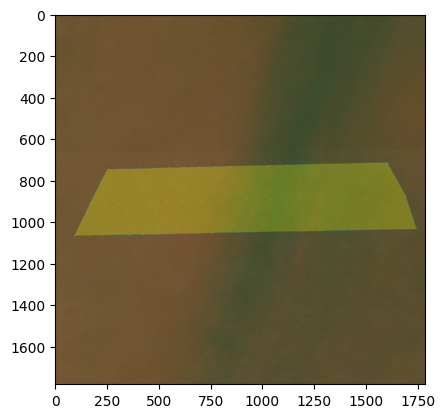

(1782, 1782, 3)


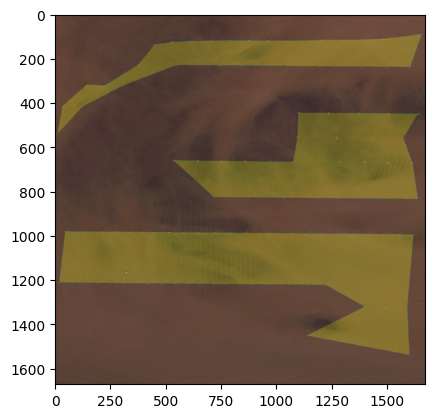

(1671, 1671, 3)


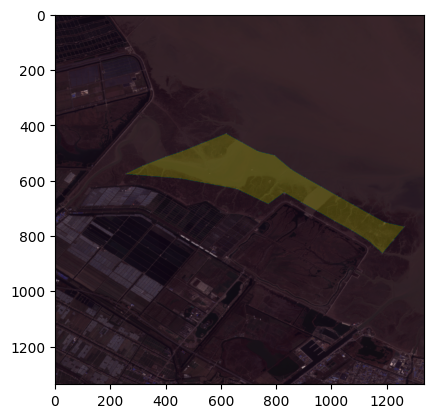

(1337, 1337, 3)


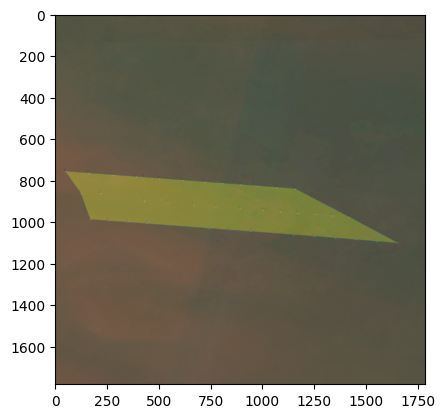

(1782, 1782, 3)


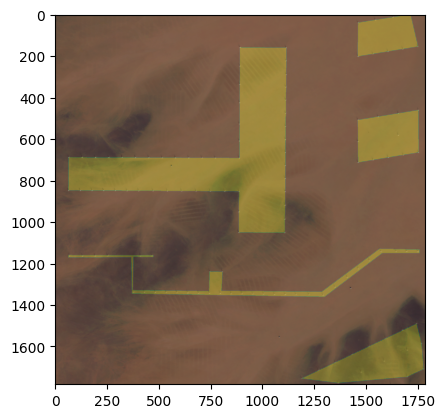

(1783, 1783, 3)


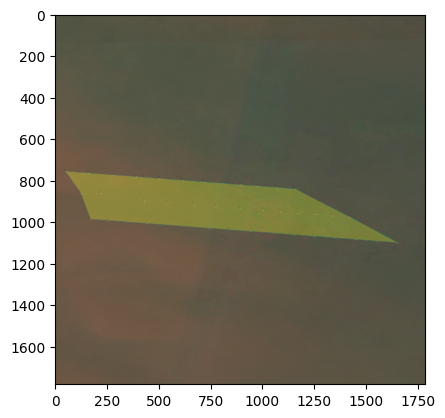

(1782, 1782, 3)


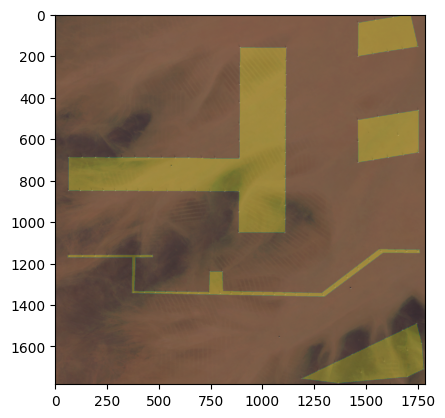

(1783, 1783, 3)


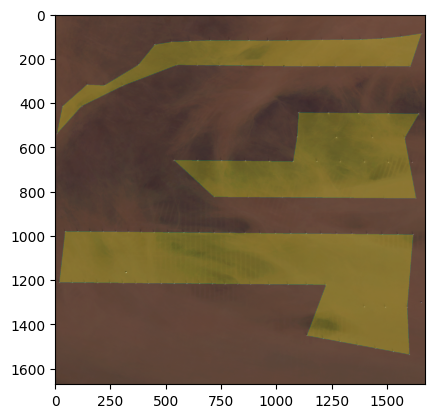

(1671, 1671, 3)


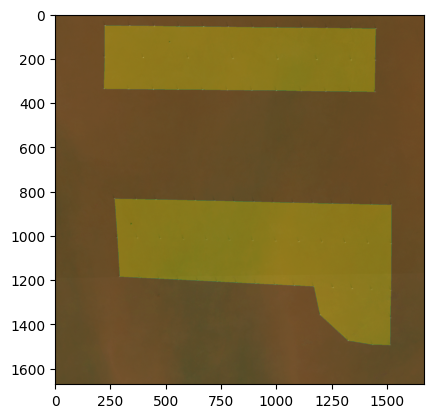

(1670, 1671, 3)


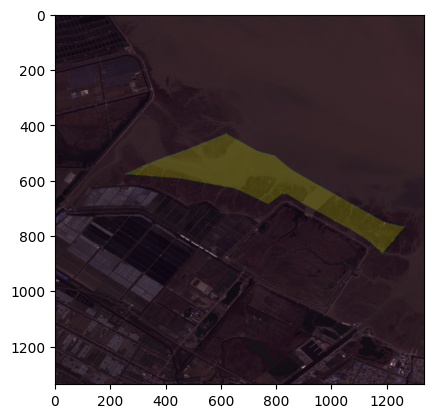

(1337, 1337, 3)


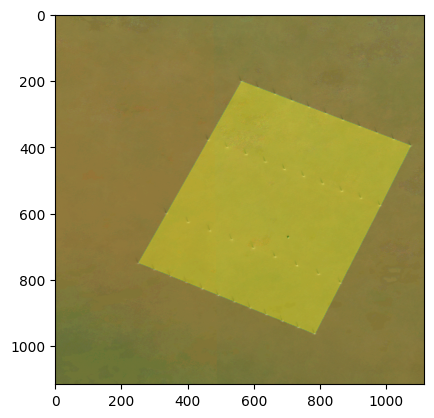

(1115, 1115, 3)


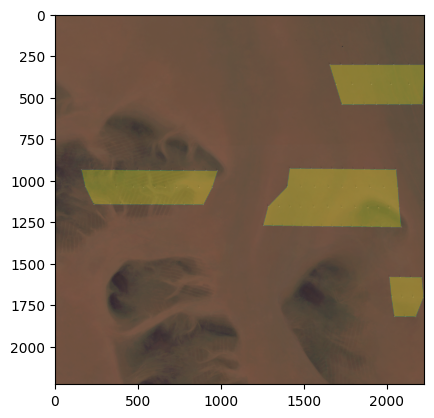

(2227, 2227, 3)


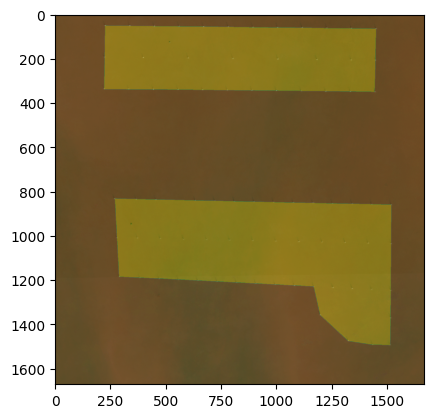

(1670, 1671, 3)


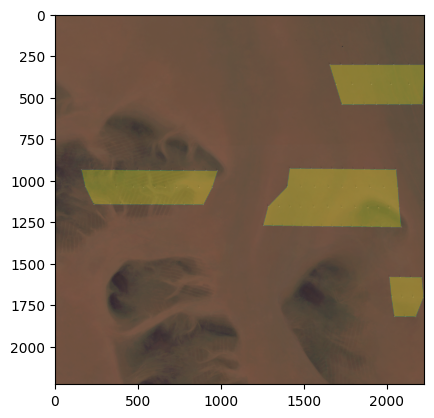

(2227, 2227, 3)


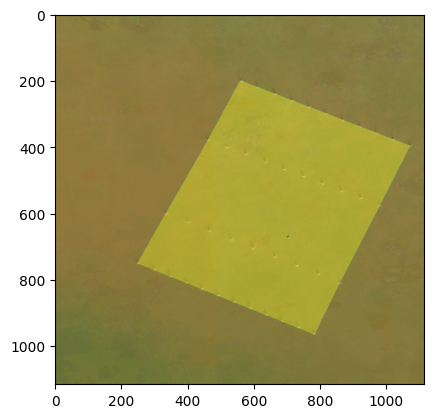

(1115, 1115, 3)


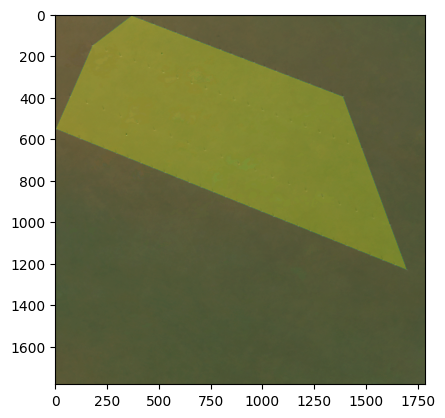

(1782, 1782, 3)


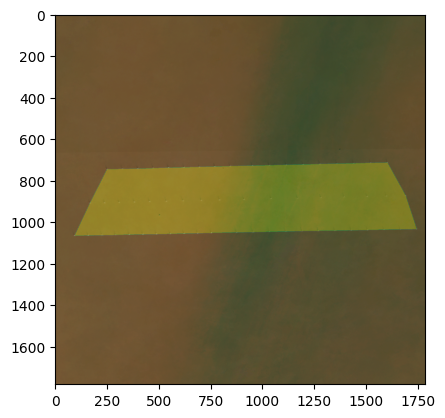

(1782, 1782, 3)


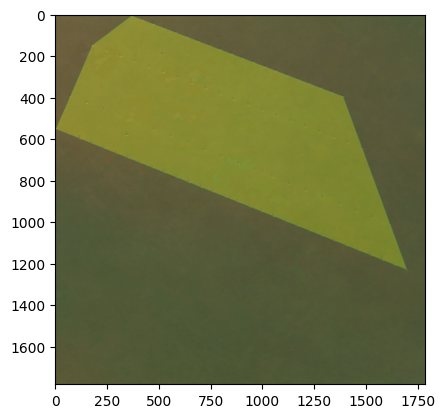

(1782, 1782, 3)


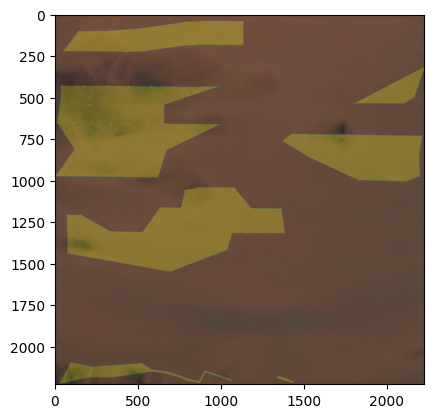

(2227, 2227, 3)


In [18]:
for file in files:
    if file[-4:] == ".npy":
        mask = np.load(
            os.path.realpath(
                os.path.join(
                    os.path.curdir, "..", "..", "data", "processed", "masks", file
                )
            )
        )

        pattern = "\d+"
        ref = re.findall(pattern, file)
        bands = np.load(
            os.path.realpath(
                os.path.join(
                    os.path.curdir,
                    "..",
                    "..",
                    "data",
                    "processed",
                    "bands",
                    file.replace("masks", "bands"),
                )
            )
        )
        rgb = np.stack([bands["B4"], bands["B3"], bands["B2"]], axis=2)
        rgb_norm = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))

        plt.imshow(rgb_norm)
        plt.imshow(mask, alpha=0.2)
        plt.show()
        print(rgb_norm.shape)